## Деревья решений и метод ближайших соседей в задаче прогнозирования оттока клиентов телеком-оператора

Считаем данные в DataFrame и проведем предобработку. Штаты пока сохраним в отдельный объект Series, но удалим из датафрейма. Первую модель будем обучать без штатов, потом посмотрим, помогают ли они. 

In [26]:
df = pd.read_csv("telecom_churn.csv")

In [27]:
df["International plan"] = pd.factorize(df["International plan"])[0]
df["Voice mail plan"] = pd.factorize(df["Voice mail plan"])[0]
df["Churn"] = df["Churn"].astype("int")
states = df["State"]
y = df["Churn"]
df.drop(["State", "Churn"], axis=1, inplace=True)

In [28]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [29]:
from sklearn.model_selection import StratifiedKFold, train_test_split

Выделим 70% выборки (X_train, y_train) под обучение и 30% будут отложенной выборкой (X_holdout, y_holdout). отложенная выборка никак не будет участвовать в настройке параметров моделей, на ней мы в конце, после этой настройки, оценим качество полученной модели.

In [30]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    df.values, y, test_size=0.3, random_state=17
)

Обучим 2 модели – дерево решений и kNN, пока не знаем, какие параметры хороши, поэтому наугад: глубину дерева берем 5, число ближайших соседей – 10.

In [31]:
from sklearn.neighbors import KNeighborsClassifier

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

In [32]:
%%time
tree.fit(X_train, y_train)

Wall time: 9.96 ms


DecisionTreeClassifier(max_depth=5, random_state=17)

In [33]:
%%time
knn.fit(X_train, y_train)

Wall time: 999 µs


KNeighborsClassifier(n_neighbors=10)

Качество прогнозов будем проверять с помощью простой метрики – доли правильных ответов

In [34]:
from sklearn.metrics import accuracy_score

Сделаем прогнозы для отложенной выборки. Видим, что метод ближайших соседей справился намного лучше. Но это мы пока выбирали параметры наугад. 

In [35]:
tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)

0.94

In [36]:
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred)

0.881

Теперь настроим параметры дерева на кросс-валидации. Настраивать будем максимальную глубину и максимальное используемое на каждом разбиении число признаков. Суть того, как работает GridSearchCV: для каждой уникальной пары значений  параметров `max_depth` и `max_features` будет проведена 5-кратная кросс-валидация и выберется лучшее сочетание параметров.

In [37]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [38]:
tree_params = {"max_depth": range(1, 11), "max_features": range(4, 19)}

In [39]:
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

In [40]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

Лучшее сочетание параметров и соответствующая средняя доля правильных ответов на кросс-валидации:

In [41]:
tree_grid.best_params_

{'max_depth': 6, 'max_features': 17}

In [42]:
tree_grid.best_score_

0.94257014456259

In [43]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.946

Теперь попробуем настроить число соседей в алгоритме kNN.

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [45]:
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_jobs=-1))]
)

In [46]:
knn_params = {"knn__n_neighbors": range(1, 10)}

In [47]:
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)

In [48]:
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 10)},
             verbose=True)

In [49]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 7}, 0.8859867109023905)

In [50]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout))

0.89

Видим, что в этом примере дерево показало себя лучше, чем метод ближайших соседей. Более того, в данной задаче дерево проявляет себя очень хорошо, и даже случайный лес (который пока представляем просто как кучу деревьев, которые вместе работают почему-то намного лучше, чем одно дерево) в этом примере показывает долю правильных ответов не намного выше (как на кросс-валидации, так и на отложенной выборке), а обучается намного дольше. 

In [51]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
print(np.mean(cross_val_score(forest, X_train, y_train, cv=5)))

0.9494233119813256


In [52]:
forest_params = {"max_depth": range(1, 11), "max_features": range(4, 19)}

In [53]:
forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)

In [54]:
forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

In [55]:
forest_grid.best_params_, forest_grid.best_score_

({'max_depth': 9, 'max_features': 6}, 0.9511372931045574)

In [56]:
accuracy_score(y_holdout, forest_grid.predict(X_holdout))

0.953

<!--
export_graphviz(tree_grid.best_estimator_, feature_names=df.columns, 
                out_file='../../img/churn_tree.dot', filled=True)
!dot -Tpng '../../img/churn_tree.dot' -o '../../img/churn_tree.png'

<img src='../../img/churn_tree.png'>
-->

## Деревья решений и метод ближайших соседей в задаче распознавания рукописных цифр MNIST

Теперь посмотрим на описанные 2 алгоритма в реальной задаче. Используемый "встроенные" в `sklearn` данные по рукописным цифрам. Эта задача будет примером, когда метод ближайших соседей работает на удивление хорошо.

In [57]:
from sklearn.datasets import load_digits

Загружаем данные.

In [58]:
data = load_digits()
X, y = data.data, data.target

Картинки здесь представляются матрицей 8 x 8 (интенсивности белого цвета для каждого пикселя). Далее эта матрица "разворачивается" в вектор длины 64, получается признаковое описание объекта.

In [59]:
X[0, :].reshape([8, 8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Нарисуем несколько рукописных цифр, видим, что они угадываются.

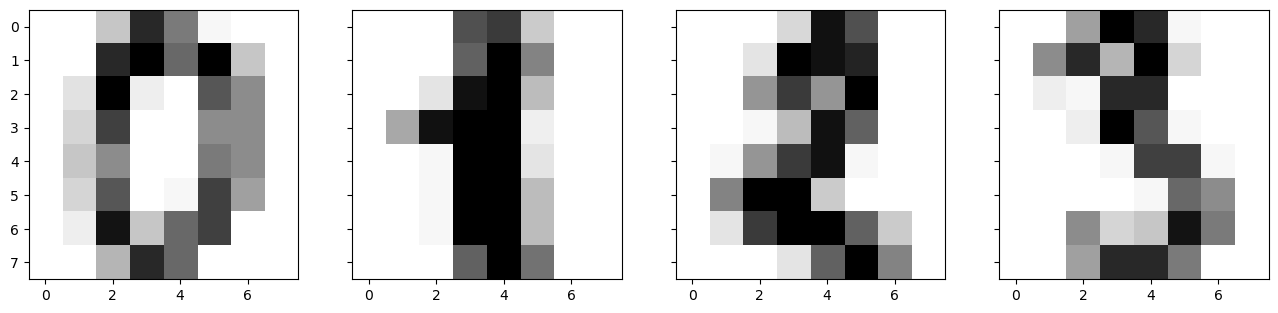

In [60]:
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 6))
for i in range(4):
    axes[i].imshow(X[i, :].reshape([8, 8]), cmap="Greys");

Посмотрим на соотношение классов в выборке, видим, что примерно поровну нулей, единиц, ..., девяток.

In [61]:
np.bincount(y)

array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180], dtype=int64)

Выделим 70% выборки (X_train, y_train) под обучение и 30% будут отложенной выборкой (X_holdout, y_holdout). отложенная выборка никак не будет участвовать в настройке параметров моделей, на ней мы в конце, после этой настройки, оценим качество полученной модели.

In [62]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.3, random_state=17
)

Обучим дерево решений и kNN, опять параметры пока наугад берем.

In [63]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

In [64]:
%%time
tree.fit(X_train, y_train)

Wall time: 12 ms


DecisionTreeClassifier(max_depth=5, random_state=17)

In [65]:
%%time
knn.fit(X_train, y_train)

Wall time: 1 ms


KNeighborsClassifier(n_neighbors=10)

Сделаем прогнозы для отложенной выборки. Видим, что метод ближайших соседей справился намного лучше. Но это мы пока выбирали параметры наугад. 

In [66]:
tree_pred = tree.predict(X_holdout)
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred), accuracy_score(y_holdout, tree_pred)

(0.9740740740740741, 0.6666666666666666)

Теперь так же, как раньше настроим параметры моделей на кросс-валидации, только учтем, что признаков сейчас больше, чем в прошлой задаче - 64. 

In [67]:
tree_params = {
    "max_depth": [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
    "max_features": [1, 2, 3, 5, 10, 20, 30, 50, 64],
}

In [68]:
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

In [69]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
                         'max_features': [1, 2, 3, 5, 10, 20, 30, 50, 64]},
             verbose=True)

Лучшее сочетание параметров и соответствующая средняя доля правильных ответов на кросс-валидации:

In [70]:
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 10, 'max_features': 50}, 0.8568203376968316)

In [71]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.8425925925925926

Это уже не 66%, но и не 97%. Метод ближайших соседей на этом наборе данных работает лучше. В случае одного ближайшего соседа на кросс-валидации достигается почти 99% угадываний.

In [72]:
np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5))

0.9864858028204642

In [73]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
accuracy_score(y_holdout, knn.predict(X_holdout))

0.9833333333333333

Обучим на этих же данных случайный лес, он на большинстве выборок работает лучше, чем метод ближайших соседей. Но сейчас у нас исключение. 

In [74]:
np.mean(
    cross_val_score(RandomForestClassifier(random_state=17), X_train, y_train, cv=5)
)

0.9753462341111744

In [75]:
rf = RandomForestClassifier(random_state=17, n_jobs=-1).fit(X_train, y_train)
accuracy_score(y_holdout, rf.predict(X_holdout))

0.9666666666666667

Вы будете правы, если возразите, что мы тут не настраивали параметры RandomForestClassifier, но даже с настройкой доля правильных ответов не достигает 98%, как для у метода одного ближайшего соседа. 